## Анализ бизнес-показателей развлекательного приложения</div>


</b> В нашем распоряжении маркетинговые данные развлекательного приложения Procrastinate Pro+ за период с 1 мая по 27 октября 2019 года. Несмотря на огромные вложения в рекламу, последние несколько месяцев компания-разработчик приложения терпит убытки. Наша задача — разобраться в причинах и помочь компании выйти в плюс. Для этого поставим сформулируем цель исследования и определим основные этапы, которые помогут понять причины убытков и представить рекомендации для отдела маркетинга.</div>


 #### Цель исследования</div>


1. Провести исследовательский анализ данных для определения направлений, отражающих количество пользователей и долю платящих пользователей.</div>
2. Осуществить маркетинговое исследование, позволяющее источники затрат и динамику изменения затрат в зависимости от направлений.</div>
3. Оценить окупаемость рекламы и определить, какие направления послужили источниками возникших проблем.</div>


#### Ход исследования</div>


</b> Маркетинговые данные мы получим из файлов `/datasets/visits_info_short.csv`, `/datasets/orders_info_short.csv`, `/datasets/costs_info_short.csv`. О качестве исходных данных ничего неизвестно, поэтому прежде, чем приступать непосредственно к исследованию, необходимо провести обзор данных.</div>
</b> Мы проверим исходные данные на предмет наличия возможных ошибок и постараемся исправить эти ошибки для исключения их влияния на дальнейшее исследование и возможность искажения полученных данных.</div>
</b> Таким образом, наше исследование будет состоять из следующих этапов:</div>


- Обзор данных</div>
- Предобработка данных</div>
- Расчеты и добавление результатов в таблицу</div>
- Определение профиля пользователя</div>
- Исследовательский анализ данных и визуальное отражение количества пользователей и доли платящих пользователей по разным направлениям (страна, рекламный канал, устройство)</div>
- Проведение маркетинговых исследований, позволяющих определить сумму расходов, распределение затрат по рекламным источникам, изменение расходов в динамике и средние затраты на привлечение пользователя из каждого источника</div>
- Анализ окупаемости рекламы с использованием графиков LTV, ROI и CAC,  получение ответов на вопросы: окупается ли реклама, какие источники могут негативно влиять на окупаемость и чем могут быть вызваны проблемы окупаемости</div>
- Определение причин неэффективности привлечения пользователей и формулировка рекомендаций для отдела маркетинга</div>

### Обзор данных, предобработка данных

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt

visits, orders, costs = (
    pd.read_csv('/datasets/visits_info_short.csv'),
    pd.read_csv('/datasets/orders_info_short.csv'),
    pd.read_csv('/datasets/costs_info_short.csv')
)

In [2]:
visits.info()
orders.info()
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   

В таблицах названия колонок написаны в разных регистрах, имеются пробелы. Приведем названия к нижнему регистру и заменим пробел нижним подчеркиванием. Также данные в колонках с датами хранятся в формате object, переведем их в формат date. Еще проанализируем данные на предмет наличия пропусков и дубликатов.

In [3]:
visits.columns = visits.columns.str.lower()
visits.rename(columns={'user id':'user_id', 'session start':'session_start', 'session end':'session_end'}, inplace = True)
orders.columns = orders.columns.str.lower()
orders.rename(columns={'user id':'user_id', 'event dt':'event_dt'}, inplace = True)
costs.columns = costs.columns.str.lower()

visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date 

In [4]:
visits.isna().sum()

user_id          0
region           0
device           0
channel          0
session_start    0
session_end      0
dtype: int64

In [5]:
orders.isna().sum()

user_id     0
event_dt    0
revenue     0
dtype: int64

In [6]:
costs.isna().sum()

dt         0
channel    0
costs      0
dtype: int64

In [7]:
visits.duplicated().sum()

0

In [8]:
orders.duplicated().sum()

0

In [9]:
costs.duplicated().sum()

0

В результате мы выяснили, что названия столбцов начинаются в разных регистрах и с пробелами и привели их к единообразию, а также выяснили, что в данных нет отсутствующих значений и дубликатов. Это поможет избежать искажения результатов исследования в дальнейшем.</div>

### Расчеты и добавление результатов в таблицу (функции для расчёта и анализа LTV, ROI, удержания и конверсии)

Разрешается использовать функции, с которыми вы познакомились в теоретических уроках.

Это функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

In [10]:
def get_profiles(sessions, orders, ad_costs):

    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [11]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    dimensions = ['payer'] + dimensions

    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return result_raw, result_grouped, result_in_time 

In [12]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
    dimensions = ['payer'] + dimensions

    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)

        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
    
    if 'cohort' in dimensions: 
        dimensions = []

    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return result_raw, result_grouped, result_in_time 

In [13]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


In [14]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )

    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon_days):

        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )

        result = result.fillna(0).cumsum(axis=1)

        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )

        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)

        result = result.div(result['cohort_size'], axis=0)

        result = result[['cohort_size'] + list(range(horizon_days))]

        result['cohort_size'] = cohort_sizes

        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        roi = result.div(cac['cac'], axis=0)

        roi = roi[~roi['cohort_size'].isin([np.inf])]

        roi['cohort_size'] = cohort_sizes

        roi['cac'] = cac['cac']

        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        return result, roi

    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    if 'cohort' in dimensions:
        dimensions = []

    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,
        result_grouped,
        result_in_time,
        roi_grouped,
        roi_in_time,
    )

In [15]:
def filter_data(df, window):
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [16]:
def plot_retention(retention, retention_history, horizon, window=7):

    plt.figure(figsize=(15, 10))

    retention = retention.drop(columns=['cohort_size', 0])
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    ax3 = plt.subplot(2, 2, 3)
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

In [17]:
def plot_conversion(conversion, conversion_history, horizon, window=7):
    plt.figure(figsize=(15, 5))
    conversion = conversion.drop(columns=['cohort_size'])
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [18]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    plt.figure(figsize=(20, 10))

    ltv = ltv.drop(columns=['cohort_size'])
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    cac_history = roi_history[['cac']]

    roi = roi.drop(columns=['cohort_size', 'cac'])
    
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    ax3 = plt.subplot(2, 3, 3, sharey=ax1)

    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

### Исследовательский анализ данных и визуальное отражение количества пользователей и доли платящих пользователей по разным направлениям (страна, рекламный канал, устройство)

- Составим профили пользователей. Определим минимальную и максимальную даты привлечения пользователей.
- Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучим рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

In [19]:
profiles = get_profiles(visits, orders, costs)
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [20]:
min_date = profiles['dt'].min() # определим минимальную дату привлечения пользователей
min_date

datetime.date(2019, 5, 1)

In [21]:
max_date = profiles['dt'].max()
max_date # а также максимальную дату

datetime.date(2019, 10, 27)

Мы составили профили пользователей и выяснили, что минимальная дата привлечения пользователей - 01 мая 2019 года, а максимальная - 27 октября 2019 года.

In [22]:
profiles_share = profiles.pivot_table(
    index=['region'], values = ['user_id', 'payer'], aggfunc = {'user_id':'nunique', 'payer':'sum'}
)
profiles_share ['share_paying'] = (profiles_share['payer']/profiles_share['user_id'])*100
profiles_share.sort_values(by=['user_id'], ascending=False)

,payer,user_id,share_paying
region,,,
United States,6902,100002,6.901862
UK,700,17575,3.982930
France,663,17450,3.799427
Germany,616,14981,4.111875


Судя по построенной таблице, отражающей количество пользователей и долю платящих из каждой страны, подавляющее большинство пользователей приходится на США и доля платящих среди них самая высокая, в остальных странах данный показатель почти в полтора раза ниже.

In [23]:
profiles_share = profiles.pivot_table(
    index=['device'], values = ['user_id', 'payer'], aggfunc = {'user_id':'nunique', 'payer':'sum'}
)
profiles_share ['share_paying'] = (profiles_share['payer']/profiles_share['user_id'])*100
profiles_share.sort_values(by=['user_id'], ascending=False)

,payer,user_id,share_paying
device,,,
iPhone,3382,54479,6.207897
Android,2050,35032,5.851793
PC,1537,30455,5.046790
Mac,1912,30042,6.364423


Если рассматривать ситуацию с пользователями и долей платящих пользователей в разрезе используемых устройств, то мы видим, что больше всего пользователей используют iPhone и доля платящих среди них уступает только пользователям, использующим Mac. Из чего можно сделать вывод, что пользователи, использующие устройства от компании Apple, в целом чаще переходят в категорию платящих. 

In [24]:
profiles_share = profiles.pivot_table(
    index=['channel'], values = ['user_id', 'payer'], aggfunc = {'user_id':'nunique', 'payer':'sum'}
)
profiles_share ['share_paying'] = (profiles_share['payer']/profiles_share['user_id'])*100
profiles_share.sort_values(by=['share_paying'], ascending=False)

,payer,user_id,share_paying
channel,,,
FaceBoom,3557,29144,12.204914
AdNonSense,440,3880,11.340206
lambdaMediaAds,225,2149,10.469986
TipTop,1878,19561,9.600736
RocketSuperAds,352,4448,7.913669
WahooNetBanner,453,8553,5.296387
YRabbit,165,4312,3.826531
MediaTornado,156,4364,3.574702
LeapBob,262,8553,3.063253


Среди рекламных источников наиболее предпочтительными являются FaceBoom, AdNonSense, lambdaMediaAds	и TipTop. Подавляющее большинство пользователей попало на ресурс посредством обычного поиска (organic), однако среди них самая маленькая доля становится плательщиками. Тем не менее если посмотреть на абсолютный показатель платящих среди таких пользователей, то видно, что количество их на третьем месте по сравнению с платными источниками, значит данный канал нельзя игнорировать.

</b> В результате проведенного анализа мы выяснили, что представленные данные охватывают период с 1 мая 2019 года по 27 октября 2019 года, подавляющее большинство пользователей приходится на США и доля платящих среди них самая высокая, в остальных странах данный показатель почти в полтора раза ниже. больше всего пользователей используют iPhone и доля платящих среди них уступает только пользователям, использующим Mac. Наиболее предпочтительными рекламными каналами являются FaceBoom, AdNonSense, lambdaMediaAds и TipTop, однако подавляющее большинство пользователей попало на ресурс посредством обычного поиска (organic).</div>

### Проведение маркетинговых исследований, позволяющих определить сумму расходов, распределение затрат по рекламным источникам, изменение расходов в динамике и средние затраты на привлечение пользователя из каждого источника

- Посчитаем общую сумму расходов на маркетинг.
- Выясним, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Построим визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику. 
- Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. 

In [25]:
round(profiles['acquisition_cost'].sum()) #высчитаем сумму расходов на маркетинг

105497

In [26]:
channel_ac = profiles.groupby('channel').agg({'acquisition_cost':'sum'}).sort_values(by='acquisition_cost', ascending=False)
channel_ac

,acquisition_cost
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


Больше всего средств потрачено для привлечения пользователей на TipTop и FaceBoom. Меньше всего на YRabbit и MediaTornado. На пользователей, попавших на ресурс через поиск, не потрачено ничего.

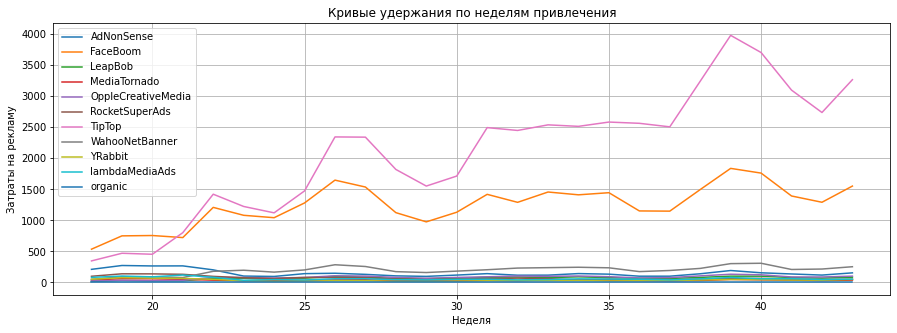

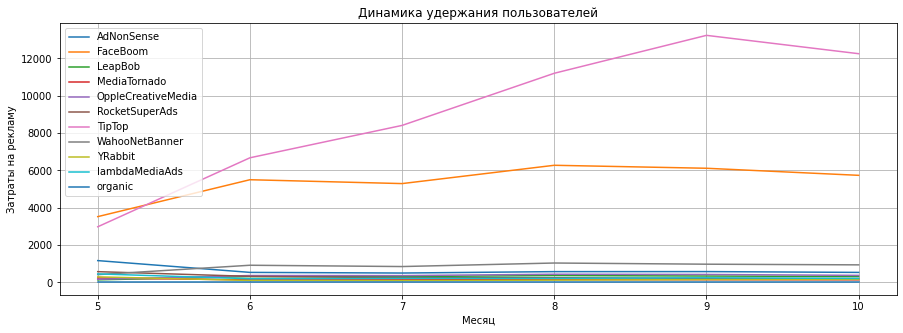

In [27]:
profiles['week'] = profiles['first_ts'].dt.isocalendar().week
profiles['month'] = profiles['first_ts'].dt.month

profiles.pivot_table(
    index='week',
    columns='channel',
    values='acquisition_cost',
    aggfunc='sum'
).plot(figsize=(15, 5), grid=True)

plt.legend()
plt.xlabel('Неделя')
plt.ylabel('Затраты на рекламу')
plt.title('Кривые удержания по неделям привлечения')

plt.show()

profiles.pivot_table(
    index='month',
    columns='channel',
    values='acquisition_cost',
    aggfunc='sum'
).plot(figsize=(15, 5), grid=True)

plt.legend()
plt.xlabel('Месяц')
plt.ylabel('Затраты на рекламу')
plt.title('Динамика удержания пользователей')

plt.show()

На построенных графиках мы видим явное лидерство в плане затрат на рекламу в каналах TipTop и FaceBoom. Однако, если рассматривать данные затраты в динамике по месяцам, то видно, что на TipTop пик затрат пришелся на сентябрь, а до этого был довольно плавный рост с мая и после сентября наблюдается снижение затрат. По каналу FaceBoom иная картина: начиная с мая виден рост затрат до июня, затем небольшое снижение, в июле опять небольшой рост до августа и затем затраты плавно снижаются. Рассматривая затраты в динамике по неделям картинка более детализирована, графики затрат по каналам TipTop и FaceBoom довольно схожи, с разницей в том, что тренд на повышение у TipTop более явный. В первые примерно 5 недель видно, что затраты у FaceBoom выше, а затем TipTop вырывается вперед и до конца рассматриваемого периода увеличивает разрыв. За весь период у обоих каналов наблюдаются резкие увеличения затрат (к 23, 26, 31 и 39 неделям) и снижения (24, 29, 43 недели).

In [28]:
channel_cost = profiles_share.merge(channel_ac, on='channel')
channel_cost['CAC'] = channel_cost['acquisition_cost']/channel_cost['user_id']
channel_cost.sort_values(by='CAC', ascending=False)

,payer,user_id,share_paying,acquisition_cost,CAC
channel,,,,,
TipTop,1878,19561,9.600736,54751.30,2.799003
FaceBoom,3557,29144,12.204914,32445.60,1.113286
AdNonSense,440,3880,11.340206,3911.25,1.008054
lambdaMediaAds,225,2149,10.469986,1557.60,0.724802
WahooNetBanner,453,8553,5.296387,5151.00,0.602245
RocketSuperAds,352,4448,7.913669,1833.00,0.412095
OppleCreativeMedia,233,8605,2.707728,2151.25,0.250000
YRabbit,165,4312,3.826531,944.22,0.218975
MediaTornado,156,4364,3.574702,954.48,0.218717


Данная таблица показывает, что лидером по стоимости привлечения пользователей является канал TipTop, затем с данным показателем в 2,5 раза ниже идет FaceBoom.

In [29]:
round(channel_cost['CAC'].mean(), 2) #рассчитаем среднюю стоимость привлечения одного клиента.

0.69

В результате анализа маркетинговых данных мы выяснили, что общая сумма расходов на рекламу составляет 105497, средняя стоимость привлечения одного клиента 0,69. Больше всего средств потрачено для привлечения пользователей на TipTop и FaceBoom. Меньше всего на YRabbit и MediaTornado. Больше всего потрачено средств на рекламу в каналах TipTop и FaceBoom. На TipTop пик затрат пришелся на сентябрь, а до этого был довольно плавный рост с мая и после сентября наблюдается снижение затрат. По каналу FaceBoom иная картина: начиная с мая виден рост затрат до июня, затем небольшое снижение, в июле опять небольшой рост до августа и затем затраты плавно снижаются.

### Анализ окупаемости рекламы с использованием графиков LTV, ROI и CAC

Используя графики LTV, ROI и CAC, проанализируйте окупаемость рекламы. Считайте, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Необходимость включения в анализ органических пользователей определите самостоятельно.

- Проанализируйте окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверьте конверсию пользователей и динамику её изменения. То же самое сделайте с удержанием пользователей. Постройте и изучите графики конверсии и удержания.
- Проанализируйте окупаемость рекламы с разбивкой по устройствам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Ответьте на такие вопросы:
    - Окупается ли реклама, направленная на привлечение пользователей в целом?
    - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    - Чем могут быть вызваны проблемы окупаемости?

Напишите вывод, опишите возможные причины обнаруженных проблем и промежуточные рекомендации для рекламного отдела.

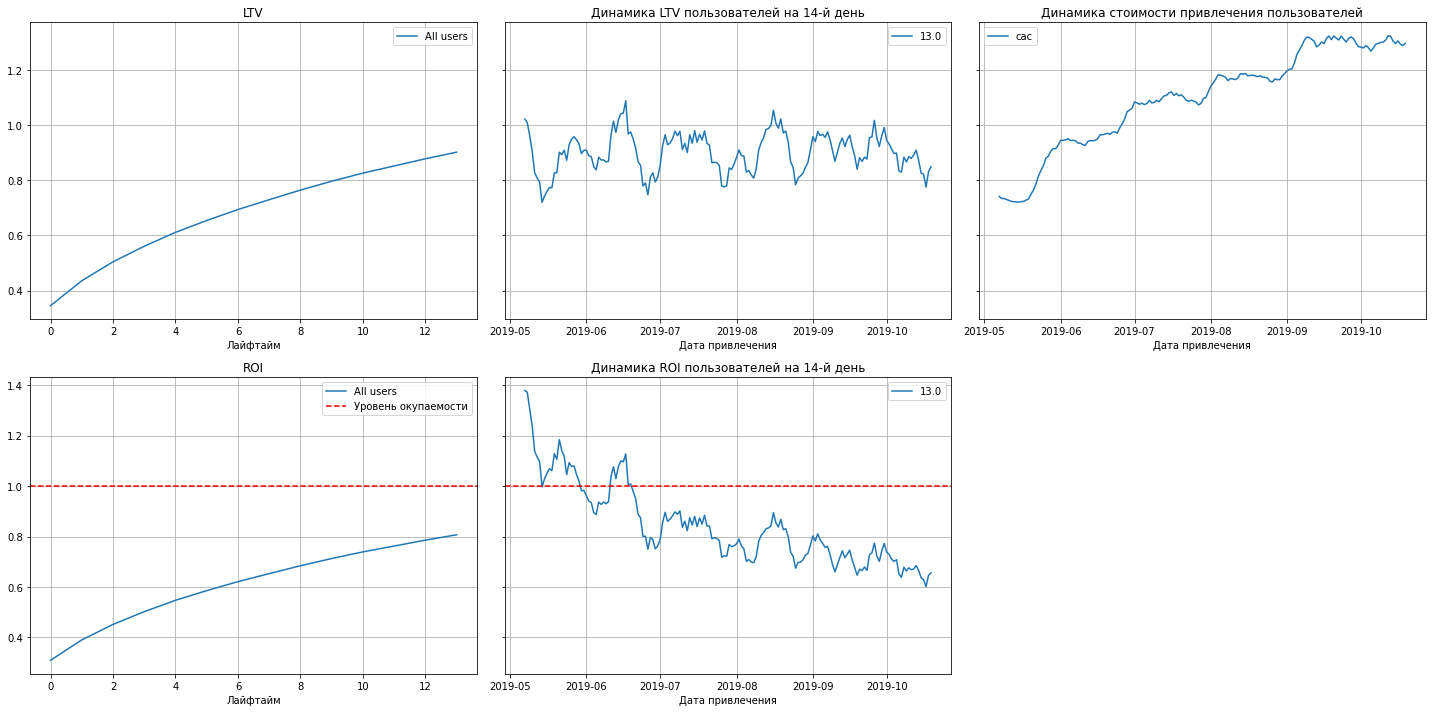

In [30]:
observation_date = datetime(2019, 11, 1).date()
horizon_days = 14
profiles = profiles.query('channel != "organic"')
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(profiles, orders, observation_date, horizon_days)
    plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days) 

График LTV показывает, что сумма денег от покупателей растет, хотя на протяжении всего периода были взлеты (как правило это происходит с начала до середины каждого месяца) и падения (в основном к концу каждого месяца). Судя по графику ROI в целом реклама приложения не окупилась и находится на уровне примерно 80%. Динамика ROI с начала периода сразу показывала падение до середины мая, затем был небольшой рост и потом к началу июня данный показатель упал ниже уровня окупаемости. Только в середине июня реклама окупалась, но затем расходы превысили доходы до конца рассматриваемого периода. Динамика стоимости привлечения клиента показывает резкий рост к середине июня, затем наблюдается более плавный рост и только к концу периода с середины сентября стоимость практически не росла. При увеличении рекламного бюджета мы видим, что возврат инвестиций практически постоянно снижается, при этом поступление средств остается в среднем на одном уровне. Значит рекламные затраты превышают доход. Попробуем разобраться из-за чего это происходит, рассмотрев влияние на ситуацию трех показателей: страны, канала рекламы и устройств, с которых пользователи посещали ресурс.

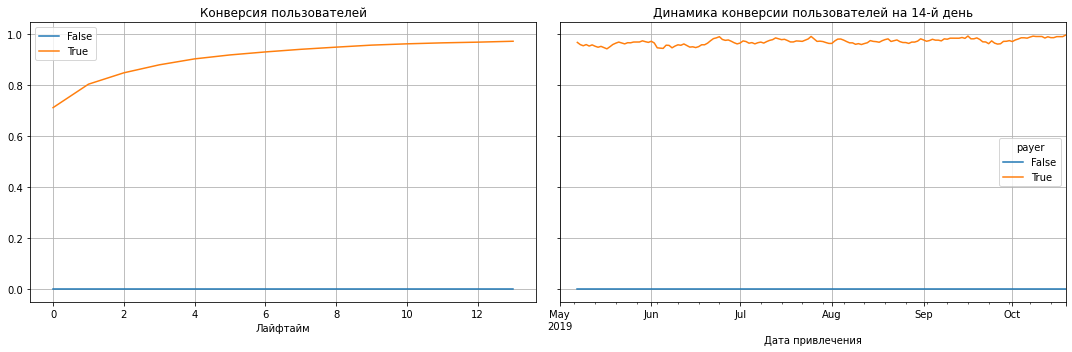

In [31]:
conversion_raw, conversion, conversion_history = get_conversion(profiles, orders, observation_date, horizon_days)
plot_conversion(conversion, conversion_history, horizon_days)

Суда по графикам конверсии переход пользователей в категорию "покупатель" в течение всего периода сохраняется примерно на одном уровне в течение всего периода, а если рассматривать горизонт события 14 дней, то видно, что кривая стремится к единице, значит данные для расчета выбраны верно.

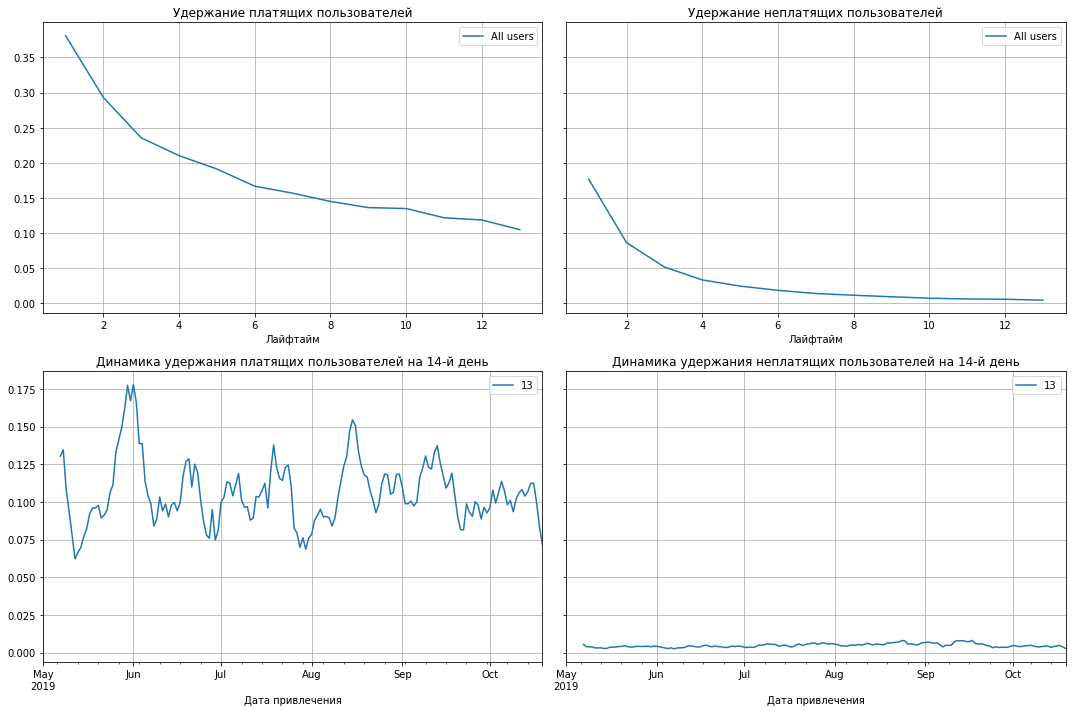

In [32]:
retention_raw, retention, retention_history = get_retention(profiles, visits, observation_date, horizon_days)
plot_retention(retention, retention_history, horizon_days)

Графики удержания пользователей показывают снижение в течение момента анализа более, чем наполовину от первоначального количества. Количество неплатящих пользователей, как и ожидалось, меньше платящих. Если рассматривать весь период, то в мае наблюдался рост удержания, но в июне он снизился. В целом уровень удержания сохранется на одном уровне, наблюдаются лишь пики: снижения к середине мая, началу июля и августа и довольно резкий рост к началу июня м середине августа). 

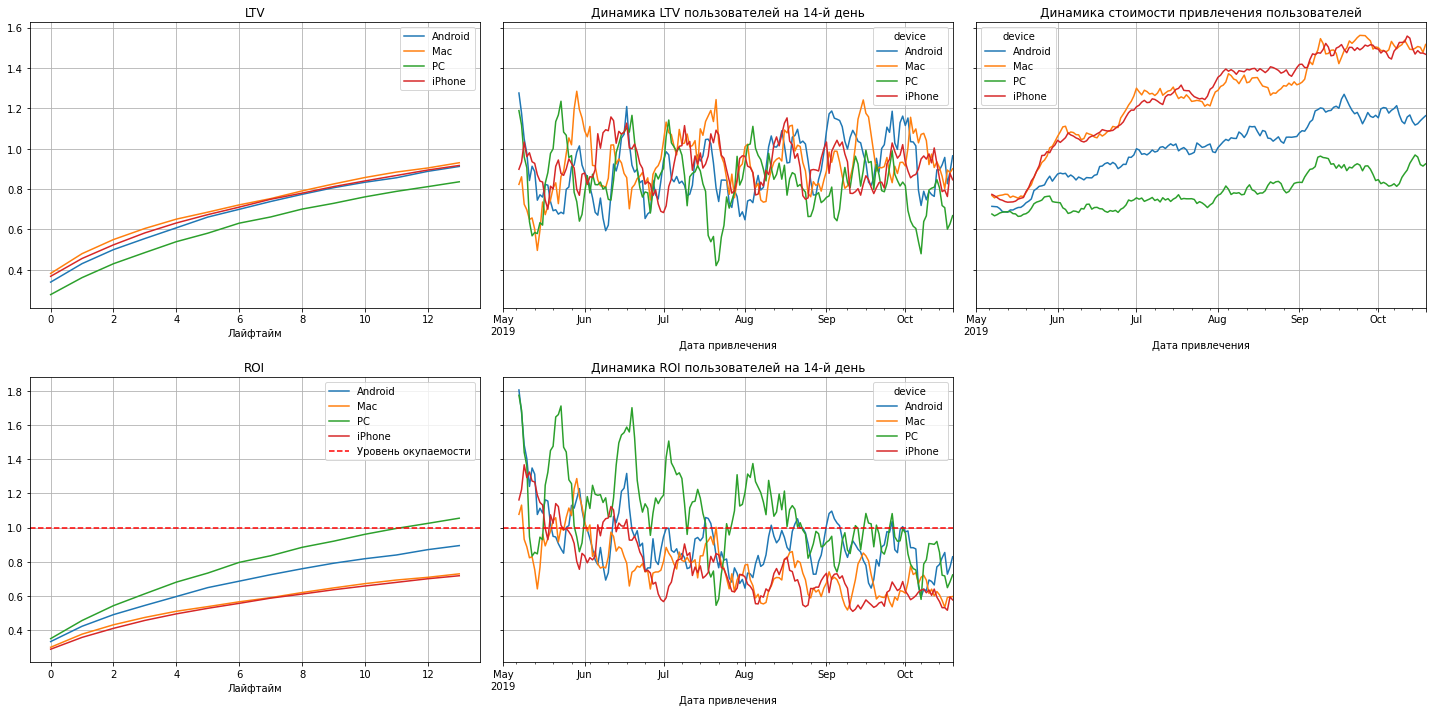

In [33]:
dimensions = ['device']

ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(profiles, orders, observation_date, horizon_days, dimensions=dimensions)
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days) 

Разбивка по устройствам показывает, что затраты почти всем рассматриваемым девайсам не окупаются, вложенные средства в конце двухнедельного периода кроме пользователей персональных компьютеров не достигают 100%, то есть доход не покрывает уровень расходов. Но и общая сумма денег, которую клиенты, пользующиеся персональными компьютерами, в среднем приносят компании со всех своих покупок меньше, чем другие клиенты. Чуть лучше ситуация по пользователям, пользующимся устройствами с операционной системой Anroid , а это примерно 95%. Если рассматривать в динамике, то ситуация схожа примерно так же по всем устройствам: динамика ROI по всему периоду лучше по PC, но к концу периода и по эти устройствам она становится ниже уровня окупаемости. При этом видно, что рекламные затраты значительно больше направлены на устройства iPhone и Mac. Однако в целом нельзя сказать, что проблемы связаны именно с устройствами.

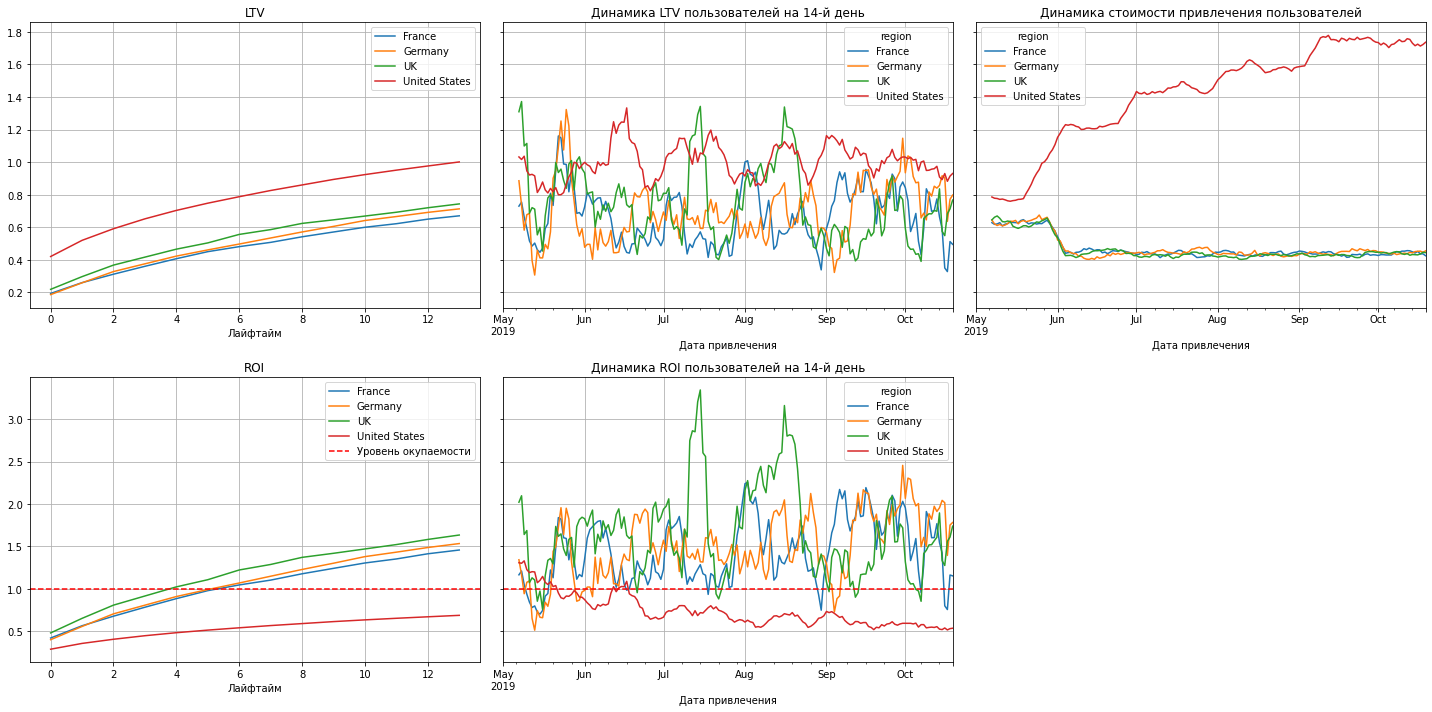

In [34]:
dimensions = ['region']

ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(profiles, orders, observation_date, horizon_days, dimensions=dimensions)
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days) 

Графики с разбивкой по странам показывают, что одна страна значительно выбивается из общей картины. На графике возврата средств по неделе и за весь период видно, что от пользователей из США средств поступаетна порядок больше, чем из других стран, при этом наблюдаются скачки в летние месяцы во Франции, Германии и Великобритании. В США таких резких изменений не наблюдается. А вот по показателю ROI США значительно всем уступает и в разрезе недели и по всему периоду, то есть расходы серьезно превышают уровень доходов. Стоимость привлечения пользователей из США очень сильно преобладает над данным показателем в других странах. Скорее всего затраты на рекламу, рассчитанную на пользователей из США, и стали причиной проблемы. Но надо рассмотреть еще все показатели по рекламным каналам.

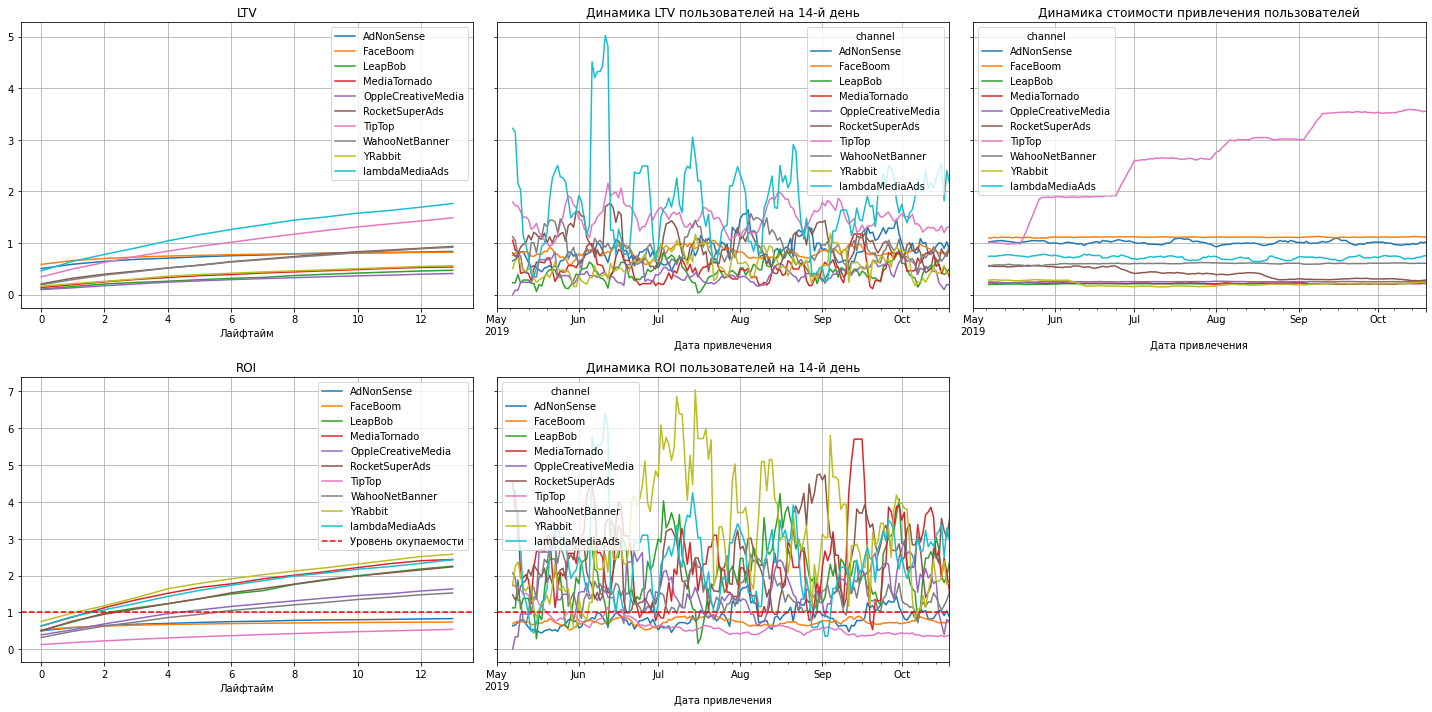

In [35]:
dimensions = ['channel']

ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(profiles, orders, observation_date, horizon_days, dimensions=dimensions)
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days)

Графики с разбивкой по рекламным каналам показывают, что проблемы по метрике ROI у каналов TipTop, FaceBoom и AdNonSense. Остальные каналы и в недельном разрезе дают превышение расходов над доходами. Если рассматривать весь период, то с окупаемостью наблюдаются проблемы у TipTop и FaceBoom. Очень сильно канал TiTop выбивается на графике, показывающем динамику стоимости привлечения клиентов, что означает довольно серьезное увеличение расходов на рекламу именно по этому каналу, по остальным ресурсам стоимость стабильна. Получается, что на проблемы с доходностью приложения влияют два показателя: расходы на рекламу для пользователей из США, пользующихся каналом TipTop. Попробуем выяснить, в чем именно проблема: в конверсии или удержании клиента.

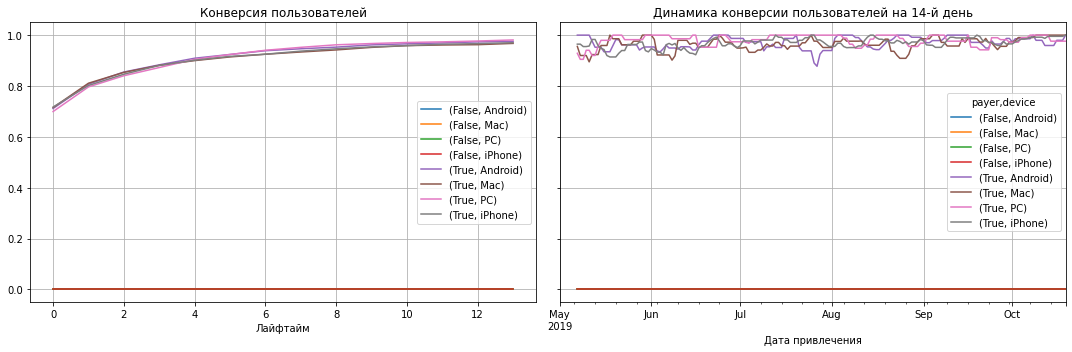

In [36]:
dimensions = ['device']

retention_raw, retention_grouped, retention_history = get_retention(profiles, visits, observation_date, horizon_days, dimensions = dimensions)
conversion_raw, conversion_grouped, conversion_history = get_conversion(profiles, orders, observation_date, horizon_days, dimensions = dimensions)
ltv_raw, ltv_grouped, ltv_history,  roi_grouped, roi_history = get_ltv(profiles, orders, observation_date, horizon_days, dimensions = dimensions)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

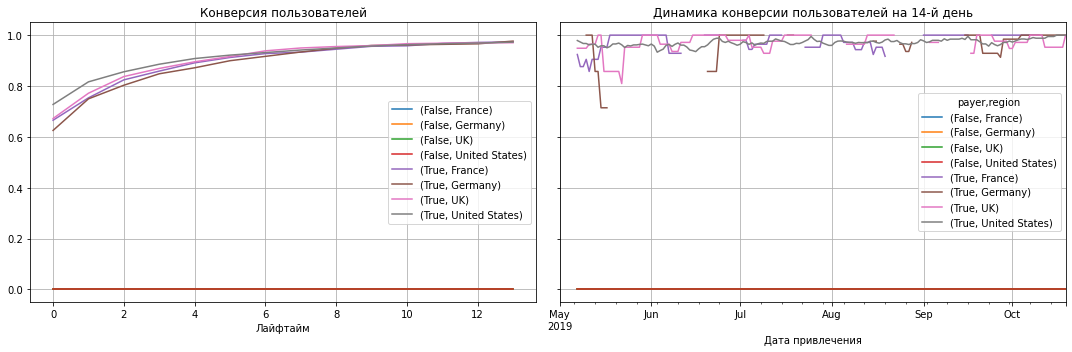

In [37]:
dimensions=['region']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Конверсия по регионам не показывает какой-то аномальной ситуации, во всех регионах конверсия платящих пользователей плавно растет в рамках недели. В динамике по всему периоду положение в целом тоже довольно ровное.

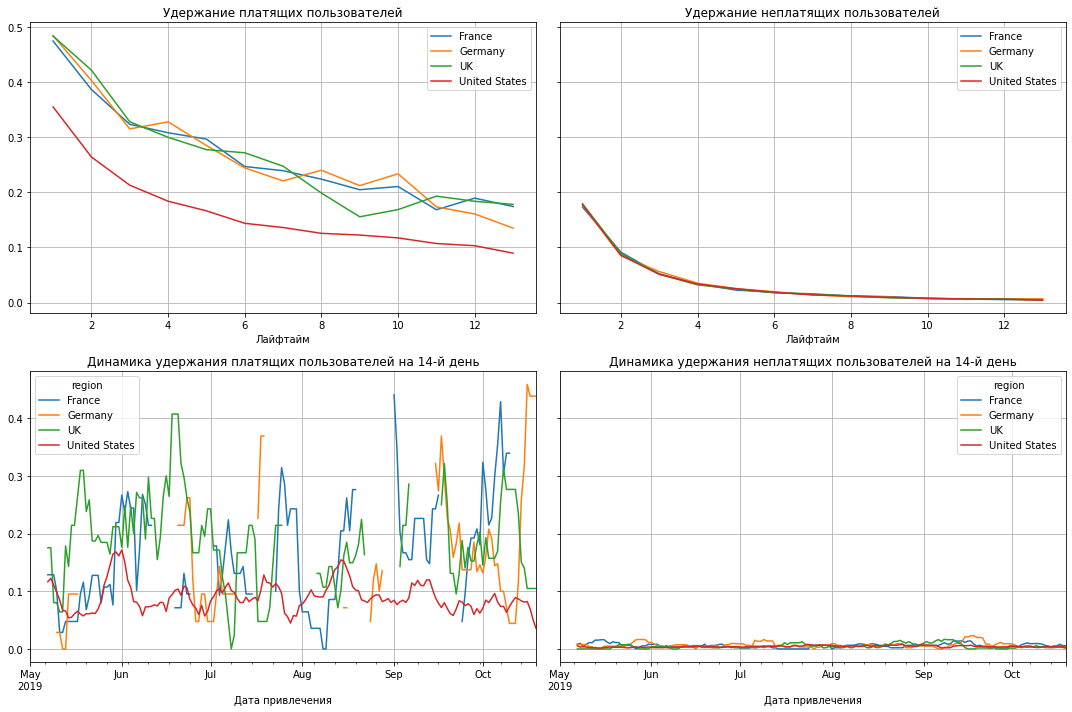

In [38]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Удержание клиентов в США и по горизонту в 14 дней и по всему периоду значительно хуже, чем в остальных странах.

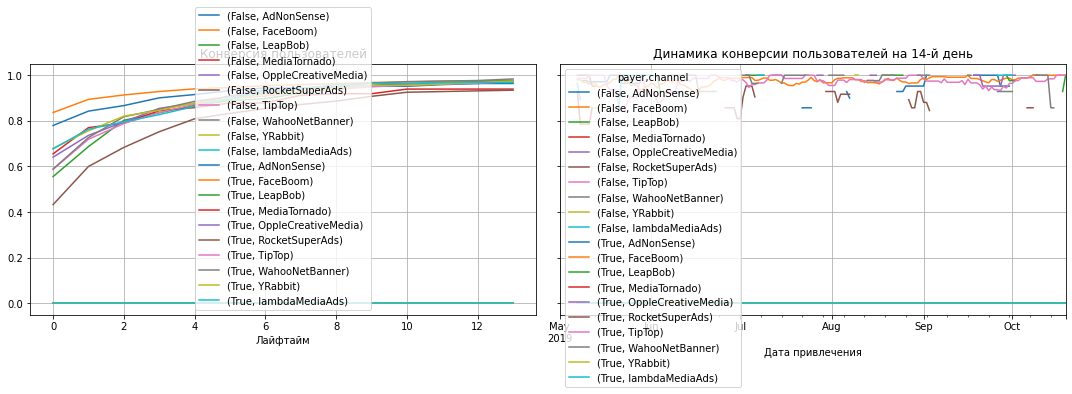

In [39]:
dimensions=['channel']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Графики конверсии по каналам показывают, что больших аномалий не наблюдается. Пользователи канала TipTop переходят в плательщики несколько хуже в начале двухнедельного периода, но затем ситуация примерно сравнивается с другими каналами. Пользователи конвертируются довольно неплохо по всем каналам и странам. Возможно проблема с удержанием.

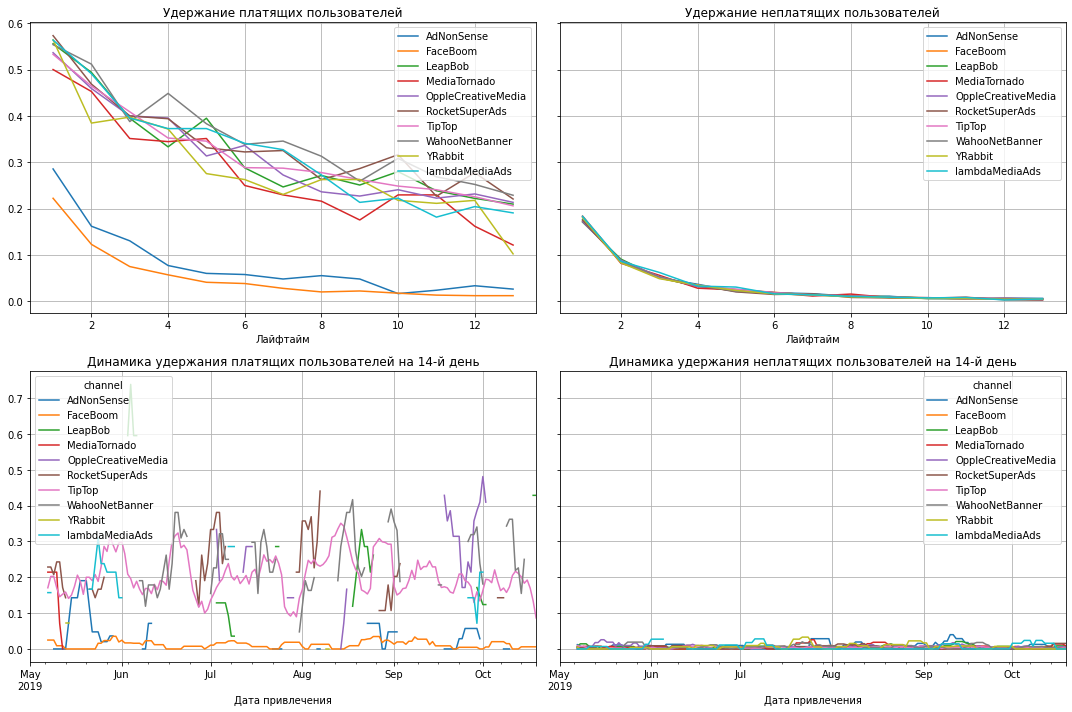

In [40]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Удержание пользователей по каналам FaceBoom и AdNonSense значительно хуже, чем по остальным каналам.

В целом реклама приложения не окупилась и находится на уровне примерно 80%. Доходность показывают только устройства PC, остальные устройства ниже уровня доходности. Рекламные затраты значительно больше направлены на устройства iPhone и Mac. Также выяснилось, что уровень превышения рекламных затрат над прибылью значительно выше в США и сами затраты на пользователей из этой страны намного больше по сравнению с другими регионами. Уровень доходности в разрезе рекламных каналов гораздо хуже у каналов TipTop, FaceBoom и AdNonSense, а на TipTop рекламные затраты показывают большой рост, в то время как по остальным каналам роста нет вообще. Анализ конверсии и удержания клиентов по регионам и рекламным каналам показал, что наблюдаются серьезные проблемы с удержанием клиентов из США в каналах FaceBoom и AdNonSense, при том, что с конверсией пользователей из США по данным каналам нет. 

### Определение причин неэффективности привлечения пользователей и формулировка рекомендаций для отдела маркетинга

- Выделите причины неэффективности привлечения пользователей.
- Сформулируйте рекомендации для отдела маркетинга.

Мы выяснили, что компания-разработчик приложения Procrastinate Pro+ несет убытки. Причиной проблем является рекламные каналы FaceBoom и AdNonSense, рассчитанные на пользователей из США, несмотря на вложенные средства, однако удержание клиентов хуже по сравнению с остальными примерно на 25%. Возможно это связано с техническими проблемами ресурсов в США.  стоило бы сократить расходы на рекламу на данном канале в рассматриваемом регионе и перенаправить средства на другие каналы, в частности Yrabbit, MediaTirnado и lambdaMediaAds.